In [2]:
%matplotlib inline 
import matplotlib.pylab as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
sns.set_style('ticks')
default_colors = sns.color_palette(); 

# Adjust all text and axes colors to black. default is some studip gray that appears to faint when printed 
from matplotlib import rc , rcParams
rc('axes',edgecolor='black')
rc('xtick',color='black',labelsize=15)
rc('ytick',color='black',labelsize=15)
rc('text',color='black')
rc('axes',labelcolor='black',linewidth=2.0)
rc('font',size=15)
rcParams["patch.force_edgecolor"] = True



import Calculate_ABA_Flinkelsteinlab as CalcABA
reload(CalcABA);

In [3]:
model_id = 'init_limit_general_energies_v2'
filename = '../data/25_10_2018/median_landscape_Boyle.txt'
boyle_params = np.loadtxt(filename,comments='#')

In [141]:
concentrations = 2**np.array(range(0,11))*0.5
reference_conc = 10
ontarget_ABA = CalcABA.calc_ABA(boyle_params, concentrations, reference_conc, 
                 mismatch_positions=[], 
                 model_id=model_id, 
                 guide_length=20, 
                 T=60*10)


delta_ABA_mat = np.zeros((20,20))

for i in range(0,20):
    for j in range(0,20):
        mismatch_positions = [20-i, 20-j]
        if i==j:
            mismatch_positions = [20-i]
        delta_ABA_mat[i,j] = CalcABA.calc_delta_ABA(boyle_params, concentrations, reference_conc, mismatch_positions,ontarget_ABA, 
                                                model_id =model_id, guide_length = 20, T=10*60)

wrong_PAM = boyle_params.copy()
wrong_PAM[0] *= 5.
nonsense_ABA = CalcABA.calc_delta_ABA(wrong_PAM, concentrations, reference_conc, mismatch_positions=range(1,21),
                                  ontarget_ABA=ontarget_ABA, 
                                                model_id =model_id, guide_length = 20, T=10*60)

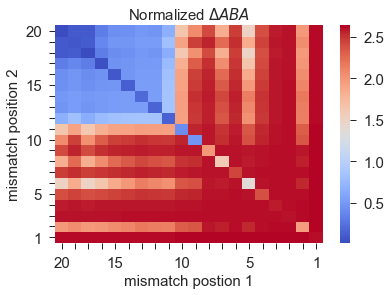

In [142]:
sns.heatmap(delta_ABA_mat, cmap='coolwarm',cbar=True);

plt.xticks([i+0.5 for i in range(20)], 
           [20,'','','',15,'','','','',10,'','','','',5,'','','','',1], rotation=0);

plt.yticks([i+0.5 for i in range(20)], 
           [1,'','','',5,'','','','',10,'','','','',15,'','','','',20], rotation=0);
plt.xlabel('mismatch postion 1', fontsize=15)
plt.ylabel('mismatch position 2', fontsize=15)
plt.title('Normalized $\Delta ABA$',fontsize=15)



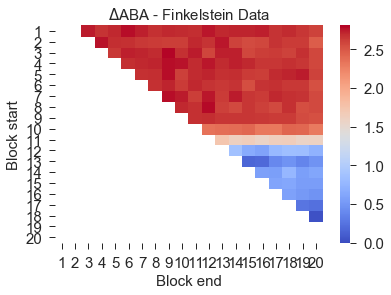

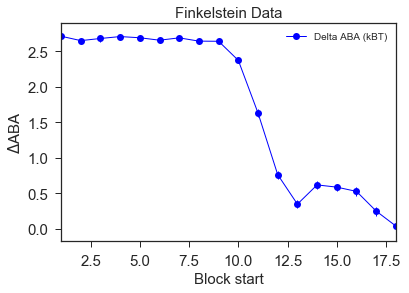

In [95]:
import sys
sys.path.append('../code_ABA_Finkelsteinlab/')
import plotting_ABA as pltABA
reload(pltABA);


IlyaData = pd.read_csv('../Data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/cas9-target-e-replicate-1-delta-abas-processed.csv')

BlockMismatches, Blocks_heatmap,ABA_first_mm_pos = pltABA.plot_block_mm_ABA(IlyaData, 
                                                               Plot=True,
                                                               SaveFigures=False,
                                                               figure_names=['../reports/fig41_10_10_2018.pdf',
                                                         '../reports/fig42_10_10_2018.pdf']);

In [182]:
def predict_block_mismatches(parameters, model_id, T=60*10,guide_length=20, show_plot=True):
    concentrations = 2**np.array(range(0,11))*0.5
    reference_conc = 10
    ontarget_ABA = CalcABA.calc_ABA(parameters, concentrations, reference_conc, 
                 mismatch_positions=[], 
                 model_id=model_id, 
                 guide_length=20, 
                 T=60*10)


    delta_ABA_mat = np.zeros((guide_length,guide_length))
    delta_ABA_mat[:] = np.nan
    
    
    for start_of_block in range(1,guide_length+1):
        for end_of_block in range(start_of_block+2,guide_length+1):
            mm_block = range(start_of_block,end_of_block)
            delta_ABA_mat[start_of_block-1,end_of_block-1] = CalcABA.calc_delta_ABA(parameters, concentrations, reference_conc, 
                     mismatch_positions=mm_block, 
                     model_id=model_id, 
                     guide_length=guide_length, 
                     T=T,
                     ontarget_ABA=ontarget_ABA)
    
    
    if show_plot:
        ax = sns.heatmap(delta_ABA_mat,cmap='coolwarm')
        plt.grid()
        ax.set_xticklabels(map(lambda x: str(int(x)), ax.get_xticks() + 0.5),fontsize=15);
        ax.set_yticklabels(map(lambda x: str(int(x)), 20 -ax.get_yticks() + 0.5), fontsize=15,rotation=0);
    return delta_ABA_mat


def predict_1D_mmblocks(parameters, model_id, T=60*10,guide_length=20, show_plot=True, show_data=True):
    concentrations = 2**np.array(range(0,11))*0.5
    reference_conc = 10
    ontarget_ABA = CalcABA.calc_ABA(parameters, concentrations, reference_conc, 
                 mismatch_positions=[], 
                 model_id=model_id, 
                 guide_length=20, 
                 T=60*10)


    delta_ABA_mat = np.zeros(guide_length-2)
    for start_of_block in range(1,guide_length-1):
        avg_delta_ABA = 0
        count = 0 
        for end_of_block in range(start_of_block+2,guide_length+1):
            mm_block = range(start_of_block,end_of_block)
            avg_delta_ABA += CalcABA.calc_delta_ABA(parameters, concentrations, reference_conc, 
                     mismatch_positions=mm_block, 
                     model_id=model_id, 
                     guide_length=guide_length, 
                     T=T,
                     ontarget_ABA=ontarget_ABA)
            count += 1 

        delta_ABA_mat[start_of_block-1] = avg_delta_ABA / float(count) 
        
        
    if show_plot:
        ax = plt.plot(range(1,guide_length-1),
                      delta_ABA_mat,
                     marker='o',
                     markersize=4,
                     markerfacecolor='white',
                     markeredgewidth=2,
                     linestyle='solid',
                     label='prediction model')
        
        
        sns.despine()
        plt.xticks(range(1,19),fontsize=15);
        plt.yticks(fontsize=15);
        plt.xlabel('start of mismatched block',fontsize=15);
        plt.ylabel(r'$\Delta \rm{ABA} \ (k_BT)$',fontsize=15)
    
        if show_data:
        
            IlyaData = pd.read_csv('../Data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/cas9-target-e-replicate-1-delta-abas-processed.csv')

            _,_,ABA_first_mm_pos = pltABA.plot_block_mm_ABA(IlyaData, 
                                                               Plot=False,
                                                               SaveFigures=False,
                                                               figure_names=[]);
        
        
            plt.errorbar(x=ABA_first_mm_pos['Block start'], 
                 y=ABA_first_mm_pos['Delta ABA (kBT)'], 
                 yerr=ABA_first_mm_pos['Uncertainty'],
                        marker='o',
                         markersize=4,
                         markerfacecolor='white',
                         markeredgewidth=2,
                         linestyle='solid',
                         capsize=5,
                         label='data Finkelstein lab'
                            )
            plt.legend(fontsize=15)
    return delta_ABA_mat




def predict_single_mm(parameters, model_id, T=60*10,guide_length=20, show_plot=True,show_data=True):
    concentrations = 2**np.array(range(0,11))*0.5
    reference_conc = 10
    ontarget_ABA = CalcABA.calc_ABA(parameters, concentrations, reference_conc, 
                 mismatch_positions=[], 
                 model_id=model_id, 
                 guide_length=20, 
                 T=60*10)
    
    
    delta_ABA = np.zeros(guide_length)
    for mm_pos in range(1,guide_length+1):
        delta_ABA[mm_pos-1] = CalcABA.calc_delta_ABA(parameters, concentrations, reference_conc, 
                     mismatch_positions=[mm_pos], 
                     model_id=model_id, 
                     guide_length=guide_length, 
                     T=T,
                     ontarget_ABA=ontarget_ABA)
    
    if show_plot:
        ax = plt.plot(range(1,guide_length+1),
                      delta_ABA,
                     marker='o',
                     markersize=4,
                     markerfacecolor='white',
                     markeredgewidth=2,
                     linestyle='solid',
                     label='prediction model')
        
        
        sns.despine()
        plt.xticks(range(1,19),fontsize=15);
        plt.yticks(fontsize=15);
        plt.xlabel('mismatch position',fontsize=15);
        plt.ylabel(r'$\Delta \rm{ABA} \ (k_BT)$',fontsize=15)
        
        if show_data:
            IlyaData = pd.read_csv('../Data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/cas9-target-e-replicate-1-delta-abas-processed.csv')
            single_mut_data_mean= pltABA.plot_single_mut_ABA(data=IlyaData,Mut_type='r', Plot=False)
            
            
            plt.errorbar(x=single_mut_data_mean['Position'], 
                                      y=single_mut_data_mean['Delta ABA (kBT)'], 
                                      yerr=single_mut_data_mean['Uncertainty'], 
                                     marker='o',
                                     markersize=4,
                                     markerfacecolor='white',
                                     markeredgewidth=2,
                                     linestyle='solid',
                                     label='data Finkelstein lab')
            plt.legend(fontsize=15)
    return delta_ABA




def predict_double_mm(parameters, model_id, T=60*10,guide_length=20, show_plot=True,show_data=True):
    concentrations = 2**np.array(range(0,11))*0.5
    reference_conc = 10
    ontarget_ABA = CalcABA.calc_ABA(parameters, concentrations, reference_conc, 
                 mismatch_positions=[], 
                 model_id=model_id, 
                 guide_length=20, 
                 T=60*10)
    
    delta_ABA_mat =np.zeros((guide_length,guide_length))
    for first_mm in range(1,guide_length+1):
        for second_mm in range(1,guide_length+1):
            delta_ABA_mat[first_mm-1,second_mm-1] = CalcABA.calc_delta_ABA(parameters, concentrations, reference_conc, 
                     mismatch_positions=[first_mm,second_mm], 
                     model_id=model_id, 
                     guide_length=guide_length, 
                     T=T,
                     ontarget_ABA=ontarget_ABA)
    
    if show_plot:
        axHeatmap = sns.heatmap(delta_ABA_mat, cmap='coolwarm',mask=np.tril(delta_ABA_mat))
        plt.grid()
        ax.set_xticklabels(map(lambda x: str(int(x)), ax.get_xticks() + 0.5),fontsize=15);
        ax.set_yticklabels(map(lambda x: str(int(x)), 20 -ax.get_yticks() + 0.5), fontsize=15,rotation=0);
        
        
        if show_data:
            IlyaData = pd.read_csv('../Data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/cas9-target-e-replicate-1-delta-abas-processed.csv')
            _,double_mut_map = pltABA.plot_double_mut_ABA(data=IlyaData,Mut_type='r',Plot=False)
            sns.heatmap(double_mut_map, cmap='coolwarm',ax=axHeatmap)
    return 

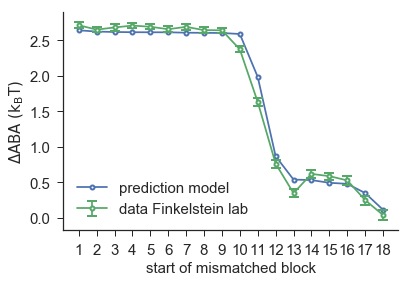

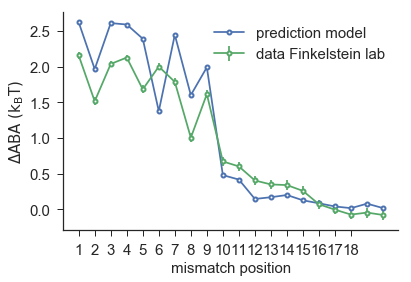

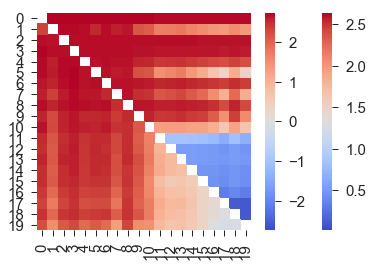

In [183]:
predict_1D_mmblocks(boyle_params, model_id, T=60*10,guide_length=20);

plt.figure()
predict_single_mm(boyle_params,model_id)


plt.figure()
predict_double_mm(boyle_params,model_id)

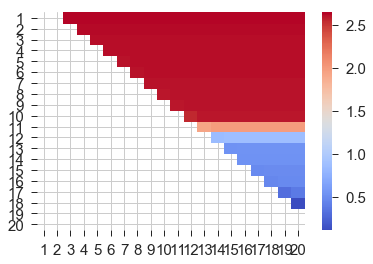

In [98]:
delta_ABA_mat = predict_block_mismatches(parameters=boyle_params, model_id=model_id, T=60*10,guide_length=20)

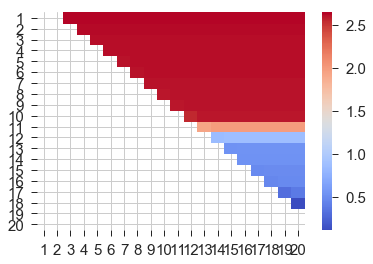

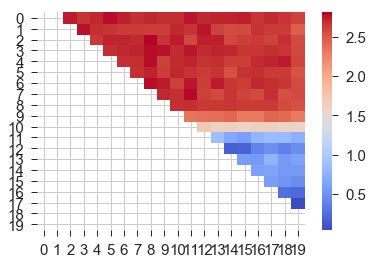

In [87]:
sns.heatmap(Blocks_heatmap, cmap='coolwarm')
# sns.heatmap(delta_ABA_mat/nonsense_ABA, cmap='coolwarm',cbar=True, mask=np.triu(delta_ABA_mat) )

plt.grid()

In [55]:
BlockMismatches.Position

0      10|12
1      10|13
2      10|14
3      10|15
4      10|16
5      10|17
6      10|18
7      10|19
8      10|20
9      11|13
10     11|14
11     11|15
12     11|16
13     11|17
14     11|18
15     11|19
16     11|20
17     12|14
18     12|15
19     12|16
20     12|17
21     12|18
22     12|19
23     12|20
24     13|15
25     13|16
26     13|17
27     13|18
28     13|19
29     13|20
       ...  
141     7|13
142     7|14
143     7|15
144     7|16
145     7|17
146     7|18
147     7|19
148     7|20
149      7|9
150     8|10
151     8|11
152     8|12
153     8|13
154     8|14
155     8|15
156     8|16
157     8|17
158     8|18
159     8|19
160     8|20
161     9|11
162     9|12
163     9|13
164     9|14
165     9|15
166     9|16
167     9|17
168     9|18
169     9|19
170     9|20
Name: Position, Length: 171, dtype: object